# Mean absolute error of DOS prediction with respect to variation in training set size 

In Part 3, we study how MAE of DOS prediction changes with respect to variation in training set size ([Schutt et al paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118)).

Import packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, train_test_split, ShuffleSplit
from sklearn import metrics

from sklearn.linear_model import LinearRegression

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Import featurized data

In [2]:
%%time
data = pd.read_pickle('./schutt_cutoff10_binsize20.pkl')

CPU times: user 11.5 s, sys: 3.33 s, total: 14.8 s
Wall time: 21 s


Drop compounds without DOS value

In [3]:
data = data.dropna(subset=['dos'])
print ("Shape of data: ", data.shape)

Shape of data:  (6174, 12085)


Count sp and spd systems

In [4]:
count = data['max_orbital'].value_counts(sort=True)

Partition compounds into sp and spd systems

In [5]:
data = data.sort_values(by=['max_orbital'])

In [6]:
systems_data = {'sp': data[:count['sp']], 'spd': data[count['sp']:]}

In [7]:
print ("Size of sp systems: ", systems_data['sp'].shape[0])
print ("Size of spd systems: ", systems_data['spd'].shape[0])

Size of sp systems:  423
Size of spd systems:  5751


Specify size of training set

In [8]:
size_sp = [10, 50] + list(np.arange(100, systems_data['sp'].shape[0] - 100, 100))
size_spd = [10, 100, 500] + list(np.arange(1000, systems_data['spd'].shape[0], 1000))

Drop unnecessary columns

In [9]:
systems_data['sp'] = systems_data['sp'].drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'volume'], 1)
systems_data['spd'] = systems_data['spd'].drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'volume'], 1)

Evaluate performance of KRR models with varied training set sizes using ShuffleSplit over 30 iterations.
- sp system testing set size: 100 
- spd system testing set size: 500

In [10]:
score_sp = dict.fromkeys(size_sp)
X, Y = systems_data['sp'].drop(['dos'], 1), systems_data['sp']['dos']
for size in size_sp:
    krr = KernelRidge(kernel='laplacian', alpha=0.0001, gamma=5e-5)
    cv = ShuffleSplit(n_splits=30, train_size=size, test_size=100)
    score_sp[size] = cross_val_score(krr, X, Y, cv=cv, scoring='neg_mean_absolute_error')

In [11]:
score_spd = dict.fromkeys(size_spd)
X, Y = systems_data['spd'].drop(['dos'], 1), systems_data['spd']['dos']
for size in size_spd:
    krr = KernelRidge(kernel='laplacian', alpha=1e-5, gamma=5e-5)
    cv = ShuffleSplit(n_splits=30, train_size=size, test_size=500)
    score_spd[size] = cross_val_score(krr, X, Y, cv=cv, scoring='neg_mean_absolute_error')

Compute aggregate statistics

In [12]:
print ("sp system score:")
for size in score_sp:
    print (size, ":", score_sp[size].mean())
print ()
print ("spd system score:")
for size in score_spd:
    print (size, ":", score_spd[size].mean())

sp system score:
10 : -0.0015183975365547805
50 : -0.001392704443407457
100 : -0.0013505691901411151
200 : -0.0013437642035577927
300 : -0.001326195708808146

spd system score:
10 : -0.00141477427672967
100 : -0.0014437697127505232
500 : -0.0013592424011286868
1000 : -0.0012777896570448657
2000 : -0.0012795992193411982
3000 : -0.001262399112633837
4000 : -0.0012979238046152773
5000 : -0.001277412544122061


Plot predictions

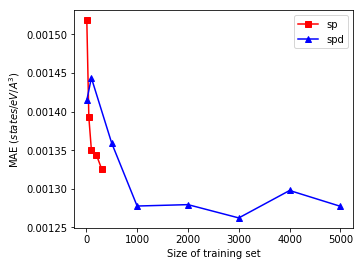

In [13]:
mae_sp = [np.abs(score_sp[size].mean()) for size in score_sp]
mae_spd = [np.abs(score_spd[size].mean()) for size in score_spd]

plt.plot(size_sp, mae_sp, color='r', marker='s', label='sp')
plt.plot(size_spd, mae_spd, color='b', marker='^', label='spd')

plt.xlabel("Size of training set")
plt.ylabel("MAE $(states/eV/A^3)$")

plt.legend()
fig = plt.gcf()
fig.set_size_inches(5,4)